#Link với Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Tạo Dataset

In [ ]:
import cv2
import os

video_folder = '/content/gdrive/MyDrive/Project_CSUD_AI/input_dataset'
dataset_folder = '/content/gdrive/MyDrive/Project_CSUD_AI/dataset'

# Định dạng nhãn của các video
labels = ['BinhThuong', 'Buon', 'GianDu', 'NgacNhien', 'VuiVe']
# Số lượng ảnh cho train và test
num_train_images = 20
num_test_images = 10

# Tạo các thư mục train và test trong dataset_folder nếu chưa tồn tại
for label in labels:
    train_folder = os.path.join(dataset_folder, 'train', label)
    test_folder = os.path.join(dataset_folder, 'test', label)
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

# Load model phát hiện khuôn mặt của OpenCV
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Hàm để trích xuất ảnh từ video và nhận diện khuôn mặt
def extract_faces_from_video(video_path, label):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Tính toán khoảng cách giữa các khung để đạt đủ số lượng ảnh cho train và test
    interval = max(total_frames // (num_train_images + num_test_images), 1)

    count = 0
    saved_train_images = 0
    saved_test_images = 0

    while cap.isOpened() and (saved_train_images < num_train_images or saved_test_images < num_test_images):
        ret, frame = cap.read()
        if not ret:
            break

        # Chuyển khung hình sang ảnh xám
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Duyệt qua từng khuôn mặt được phát hiện
        for (x, y, w, h) in faces:
            # Cắt khuôn mặt và thay đổi kích thước
            face = gray[y:y+h, x:x+w]
            face_resized = cv2.resize(face, (48, 48))

            # Lưu ảnh cho thư mục train
            if saved_train_images < num_train_images and count % interval == 0:
                train_image_path = os.path.join(dataset_folder, 'train', label, f"{os.path.basename(video_path).split('.')[0]}_{saved_train_images}.jpg")
                cv2.imwrite(train_image_path, face_resized)
                saved_train_images += 1

            # Lưu ảnh cho thư mục test
            if saved_test_images < num_test_images and count % interval == 0:
                test_image_path = os.path.join(dataset_folder, 'test', label, f"{os.path.basename(video_path).split('.')[0]}_{saved_test_images}.jpg")
                cv2.imwrite(test_image_path, face_resized)
                saved_test_images += 1

        count += 1

    cap.release()
    print(f"Đã lưu {saved_train_images} ảnh vào thư mục train và {saved_test_images} ảnh vào thư mục test từ video {video_path} vào nhãn {label}.")

# Lặp qua từng nhãn và video, trích xuất ảnh
for label in labels:
    label_videos_folder = os.path.join(video_folder, label)

    # Kiểm tra xem thư mục chứa video có tồn tại không
    if not os.path.exists(label_videos_folder):
        print(f"Thư mục {label_videos_folder} không tồn tại. Vui lòng kiểm tra lại.")
        continue

    # Lấy danh sách các video trong thư mục
    videos = [v for v in os.listdir(label_videos_folder) if v.endswith(('.mp4', '.avi', '.mov'))]

    # Kiểm tra nếu không có video nào trong thư mục
    if len(videos) == 0:
        print(f"Không tìm thấy video nào trong thư mục {label_videos_folder}.")
        continue

    # Trích xuất ảnh từ mỗi video
    for video in videos:
        video_path = os.path.join(label_videos_folder, video)
        extract_faces_from_video(video_path, label)


Đã lưu 20 ảnh vào thư mục train và 10 ảnh vào thư mục test từ video /content/gdrive/MyDrive/Project_CSUD_AI/input_dataset/BinhThuong/BinhThuong1.mp4 vào nhãn BinhThuong.
Đã lưu 20 ảnh vào thư mục train và 10 ảnh vào thư mục test từ video /content/gdrive/MyDrive/Project_CSUD_AI/input_dataset/Buon/Buon1.mp4 vào nhãn Buon.
Đã lưu 20 ảnh vào thư mục train và 10 ảnh vào thư mục test từ video /content/gdrive/MyDrive/Project_CSUD_AI/input_dataset/GianDu/GianDu1.mp4 vào nhãn GianDu.
Đã lưu 20 ảnh vào thư mục train và 10 ảnh vào thư mục test từ video /content/gdrive/MyDrive/Project_CSUD_AI/input_dataset/NgacNhien/NgacNhien1.mp4 vào nhãn NgacNhien.
Đã lưu 20 ảnh vào thư mục train và 10 ảnh vào thư mục test từ video /content/gdrive/MyDrive/Project_CSUD_AI/input_dataset/VuiVe/VuiVe1.mp4 vào nhãn VuiVe.


#Train Model

In [2]:
#Import thư viện
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
#Load dataset
train = '/content/gdrive/MyDrive/Project_CSUD_AI/dataset/train'
val = '/content/gdrive/MyDrive/Project_CSUD_AI/dataset/test'

In [4]:
#xử lí data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train,
        target_size=(48,48),
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val,
        target_size=(48,48),
        color_mode="grayscale",
        class_mode='categorical')

Found 5000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [5]:
#Tạo layer model
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Dropout(0.3))

model.add(MaxPooling2D(pool_size=(2, 2))) #24

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #12
model.add(Dropout(0.3))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #6
model.add(Dropout(0.3))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,408,965 (35.89 MB)

 Trainable params: 9,408,965 (35.89 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
#training model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-7),metrics=['accuracy'])
batch_size = 32
history = model.fit(
        train_generator,
        steps_per_epoch=int(5000 / batch_size),
        epochs=100,
        verbose = 1,
        validation_data=validation_generator,
        validation_steps=int(1000 / batch_size)
)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


156/156 ━━━━━━━━━━━━━━━━━━━━ 1425s 9s/step - accuracy: 0.1962 - loss: 1.6104 - val_accuracy: 0.2601 - val_loss: 1.6075
Epoch 2/100
  1/156 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.2812 - loss: 1.5989

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2812 - loss: 1.5989 - val_accuracy: 0.0000e+00 - val_loss: 1.6164
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 58s 131ms/step - accuracy: 0.2162 - loss: 1.6078 - val_accuracy: 0.2036 - val_loss: 1.6085
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 149us/step - accuracy: 0.3125 - loss: 1.6055 - val_accuracy: 0.2500 - val_loss: 1.6167
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.2407 - loss: 1.5984 - val_accuracy: 0.2752 - val_loss: 1.5839
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 120us/step - accuracy: 0.1875 - loss: 1.6329 - val_accuracy: 0.0000e+00 - val_loss: 1.5988
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.2715 - loss: 1.5810 - val_accuracy: 0.2752 - val_loss: 1.5858
Epoch 8/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.2812 - loss: 1.5816 - val_accuracy: 0.3750 - val_loss: 1.5202
Epoch 9/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.2889 - loss: 1.5

In [7]:
#Lưu model
model_json = model.to_json()
with open("/content/gdrive/MyDrive/Project_CSUD_AI/model/model_arch.json", "w") as json_file:
    json_file.write(model_json)
model.save('/content/gdrive/MyDrive/Project_CSUD_AI/model/my_model.h5')

Sai số kiểm tra là:  0.8672602772712708
Độ chính xác kiểm tra là:  0.6759999990463257


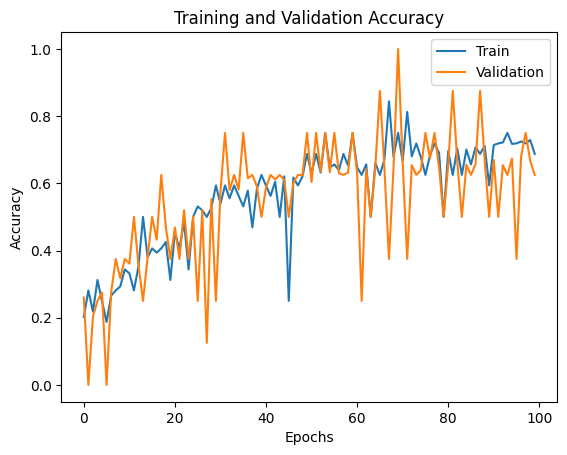

In [10]:
#đánh giá sự chính xác model
score = model.evaluate(validation_generator,verbose=0)
print('Sai số kiểm tra là: ',score[0])
print('Độ chính xác kiểm tra là: ',score[1])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train','Validation'])
plt.title('Training and Validation Accuracy')
plt.show()

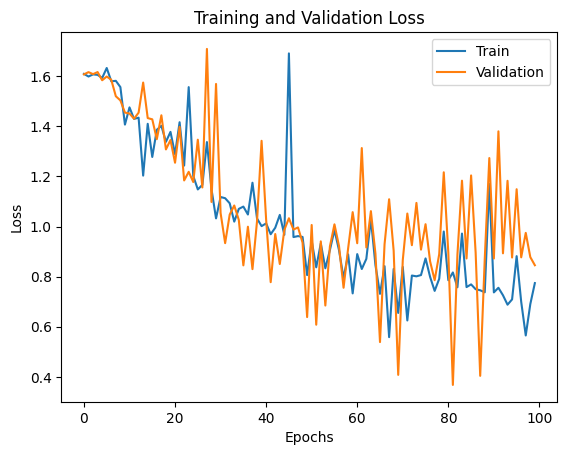

In [9]:
# Vẽ đồ thị hàm loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])
plt.title('Training and Validation Loss')
plt.show()